In [1]:
!pip install -U gdown -q
!pip install ultralytics -q
!pip install "numpy<2.0" -U
!pip install opencv-python-headless==4.8.0.74
!pip install gradio -q
!pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import gdown
import zipfile
import os
import shutil
import random
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
from PIL import Image
from ultralytics import YOLO
import gradio as gr
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import zipfile
import matplotlib

In [35]:
matplotlib.use('TkAgg')
%matplotlib inline

In [5]:
data_dir = './dataset'
yolo_dir = './yolo_dir'
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'annotations') 

os.makedirs(os.path.join(yolo_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir, 'labels/val'), exist_ok=True)

classes = ['with_mask', 'without_mask']

In [6]:
!gdown 1nng7lMDXqTT4Hrmje0BCSf5nq-9jc3QF

with zipfile.ZipFile('./MaskFaceDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

Downloading...
From (original): https://drive.google.com/uc?id=1nng7lMDXqTT4Hrmje0BCSf5nq-9jc3QF
From (redirected): https://drive.google.com/uc?id=1nng7lMDXqTT4Hrmje0BCSf5nq-9jc3QF&confirm=t&uuid=fbea1300-6a47-4d7a-86e6-e7e5b68b998e
To: d:\Workspace\Learning\Subjects\Image_Processing\Labs\Lab5\MaskFaceDataset.zip

  0%|          | 0.00/417M [00:00<?, ?B/s]
  0%|          | 524k/417M [00:00<03:45, 1.84MB/s]
  0%|          | 1.57M/417M [00:00<01:33, 4.44MB/s]
  1%|          | 3.15M/417M [00:00<00:53, 7.74MB/s]
  1%|▏         | 5.24M/417M [00:00<00:35, 11.6MB/s]
  2%|▏         | 8.39M/417M [00:00<00:24, 16.5MB/s]
  3%|▎         | 11.0M/417M [00:00<00:21, 19.0MB/s]
  3%|▎         | 13.1M/417M [00:00<00:21, 19.2MB/s]
  4%|▍         | 16.3M/417M [00:01<00:18, 22.2MB/s]
  5%|▍         | 19.4M/417M [00:01<00:16, 23.8MB/s]
  5%|▌         | 22.5M/417M [00:01<00:15, 24.8MB/s]
  6%|▌         | 25.2M/417M [00:01<00:16, 23.7MB/s]
  7%|▋         | 28.3M/417M [00:01<00:15, 25.0MB/s]
  8%|▊         | 3

In [7]:
def convert_box(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x*dw, y*dh, w*dw, h*dh)

def convert_annotation(xml_file, output_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    with open(output_path, 'w') as out_file:
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult) == 1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert_box((w, h), b)
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

# Data

In [8]:
all_xmls = [f for f in os.listdir(label_dir) if f.endswith('.xml')]
random.seed(42)
random.shuffle(all_xmls)

split_ratio = 0.8 
train_files = all_xmls[:int(len(all_xmls)*split_ratio)]
val_files = all_xmls[int(len(all_xmls)*split_ratio):]

In [14]:
for xml_file in tqdm(train_files):
    image_name = xml_file.replace('.xml', '.png') 
    src_img = os.path.join(image_dir, image_name)
    dst_img = f'./yolo_dir/images/train/{image_name}'
    if os.path.exists(src_img):
        shutil.copy(src_img, dst_img)
        convert_annotation(os.path.join(label_dir, xml_file), 
                           f'./yolo_dir/labels/train/{xml_file.replace(".xml", ".txt")}')

for xml_file in tqdm(val_files):
    image_name = xml_file.replace('.xml', '.png')
    src_img = os.path.join(image_dir, image_name)
    dst_img = f'./yolo_dir/images/val/{image_name}'
    if os.path.exists(src_img):
        shutil.copy(src_img, dst_img)
        convert_annotation(os.path.join(label_dir, xml_file), 
                           f'./yolo_dir/labels/val/{xml_file.replace(".xml", ".txt")}')

  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

In [17]:
yaml_content = f"""
train: ./yolo_dir/images/train
val: ./yolo_dir/images/val

nc: 2
names: ['with_mask', 'without_mask']
"""

with open('data.yaml', 'w') as f:
    f.write(yaml_content)

# Training

In [18]:
model = YOLO('yolov8n.pt') 

results = model.train(
    data='data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='mask_detection_model', 
    device=0,
    amp=False,
    workers=0
)

Ultralytics 8.3.231  Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_detection_model5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

# Evaluation

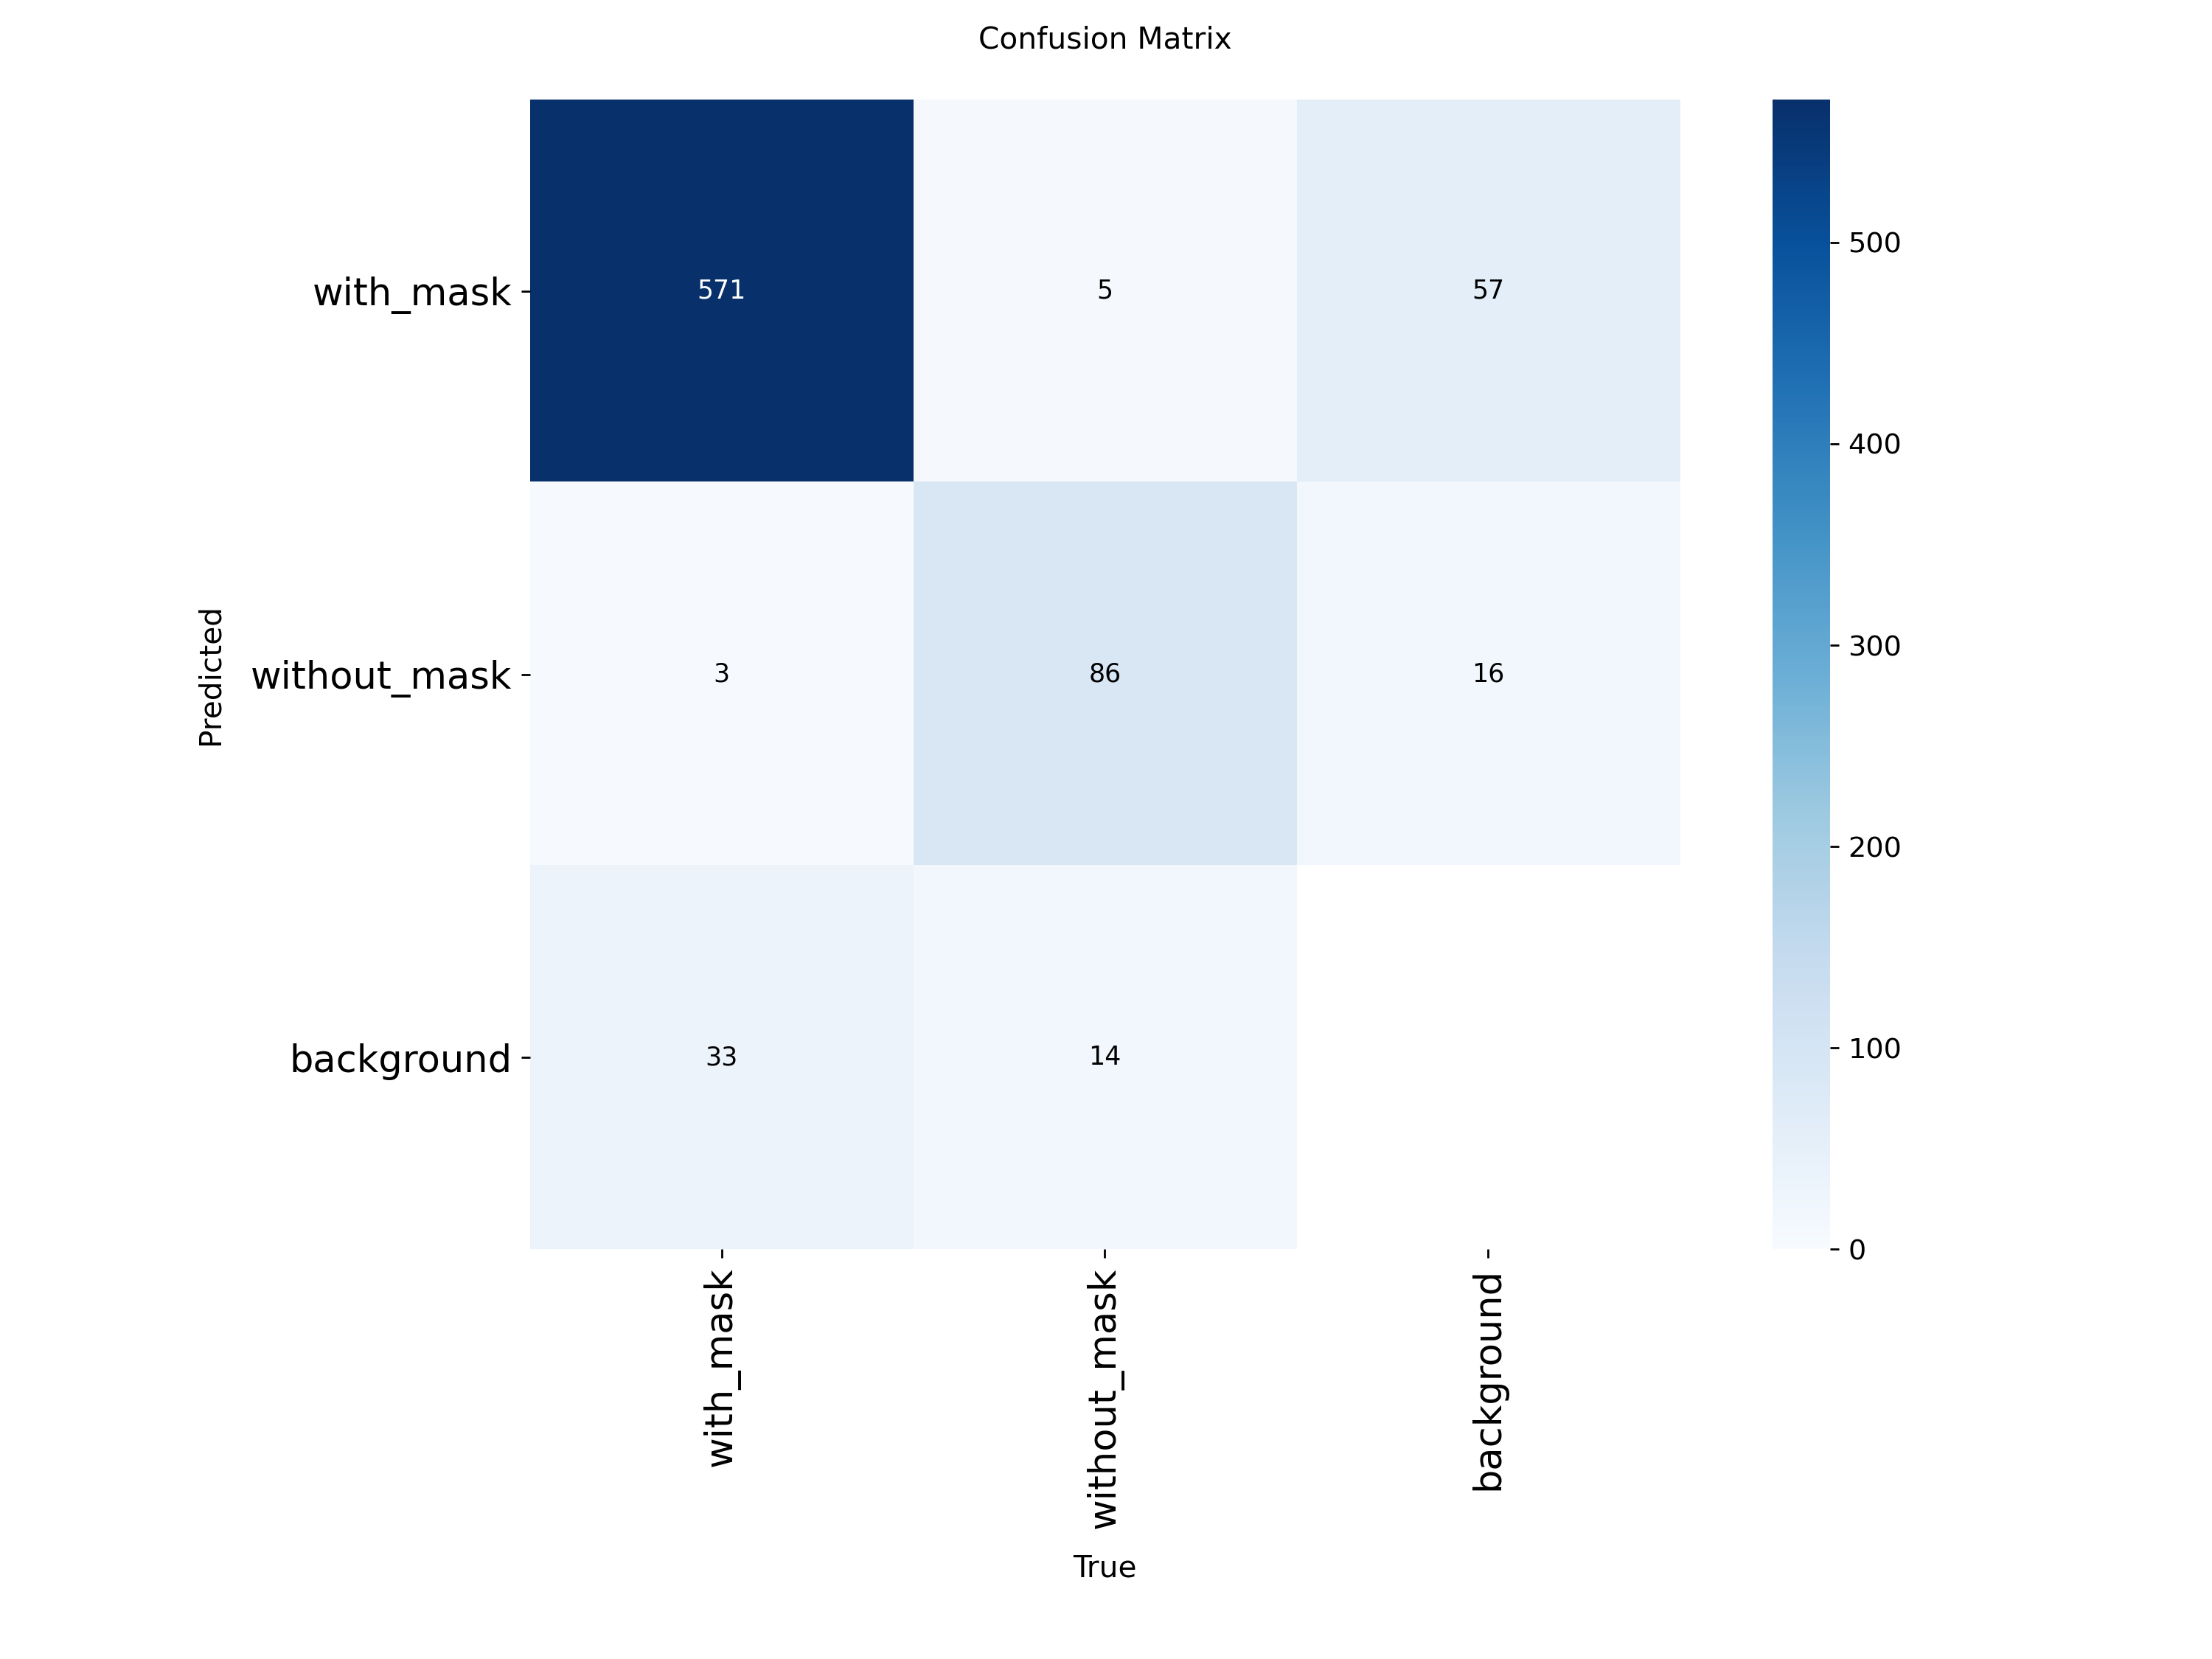

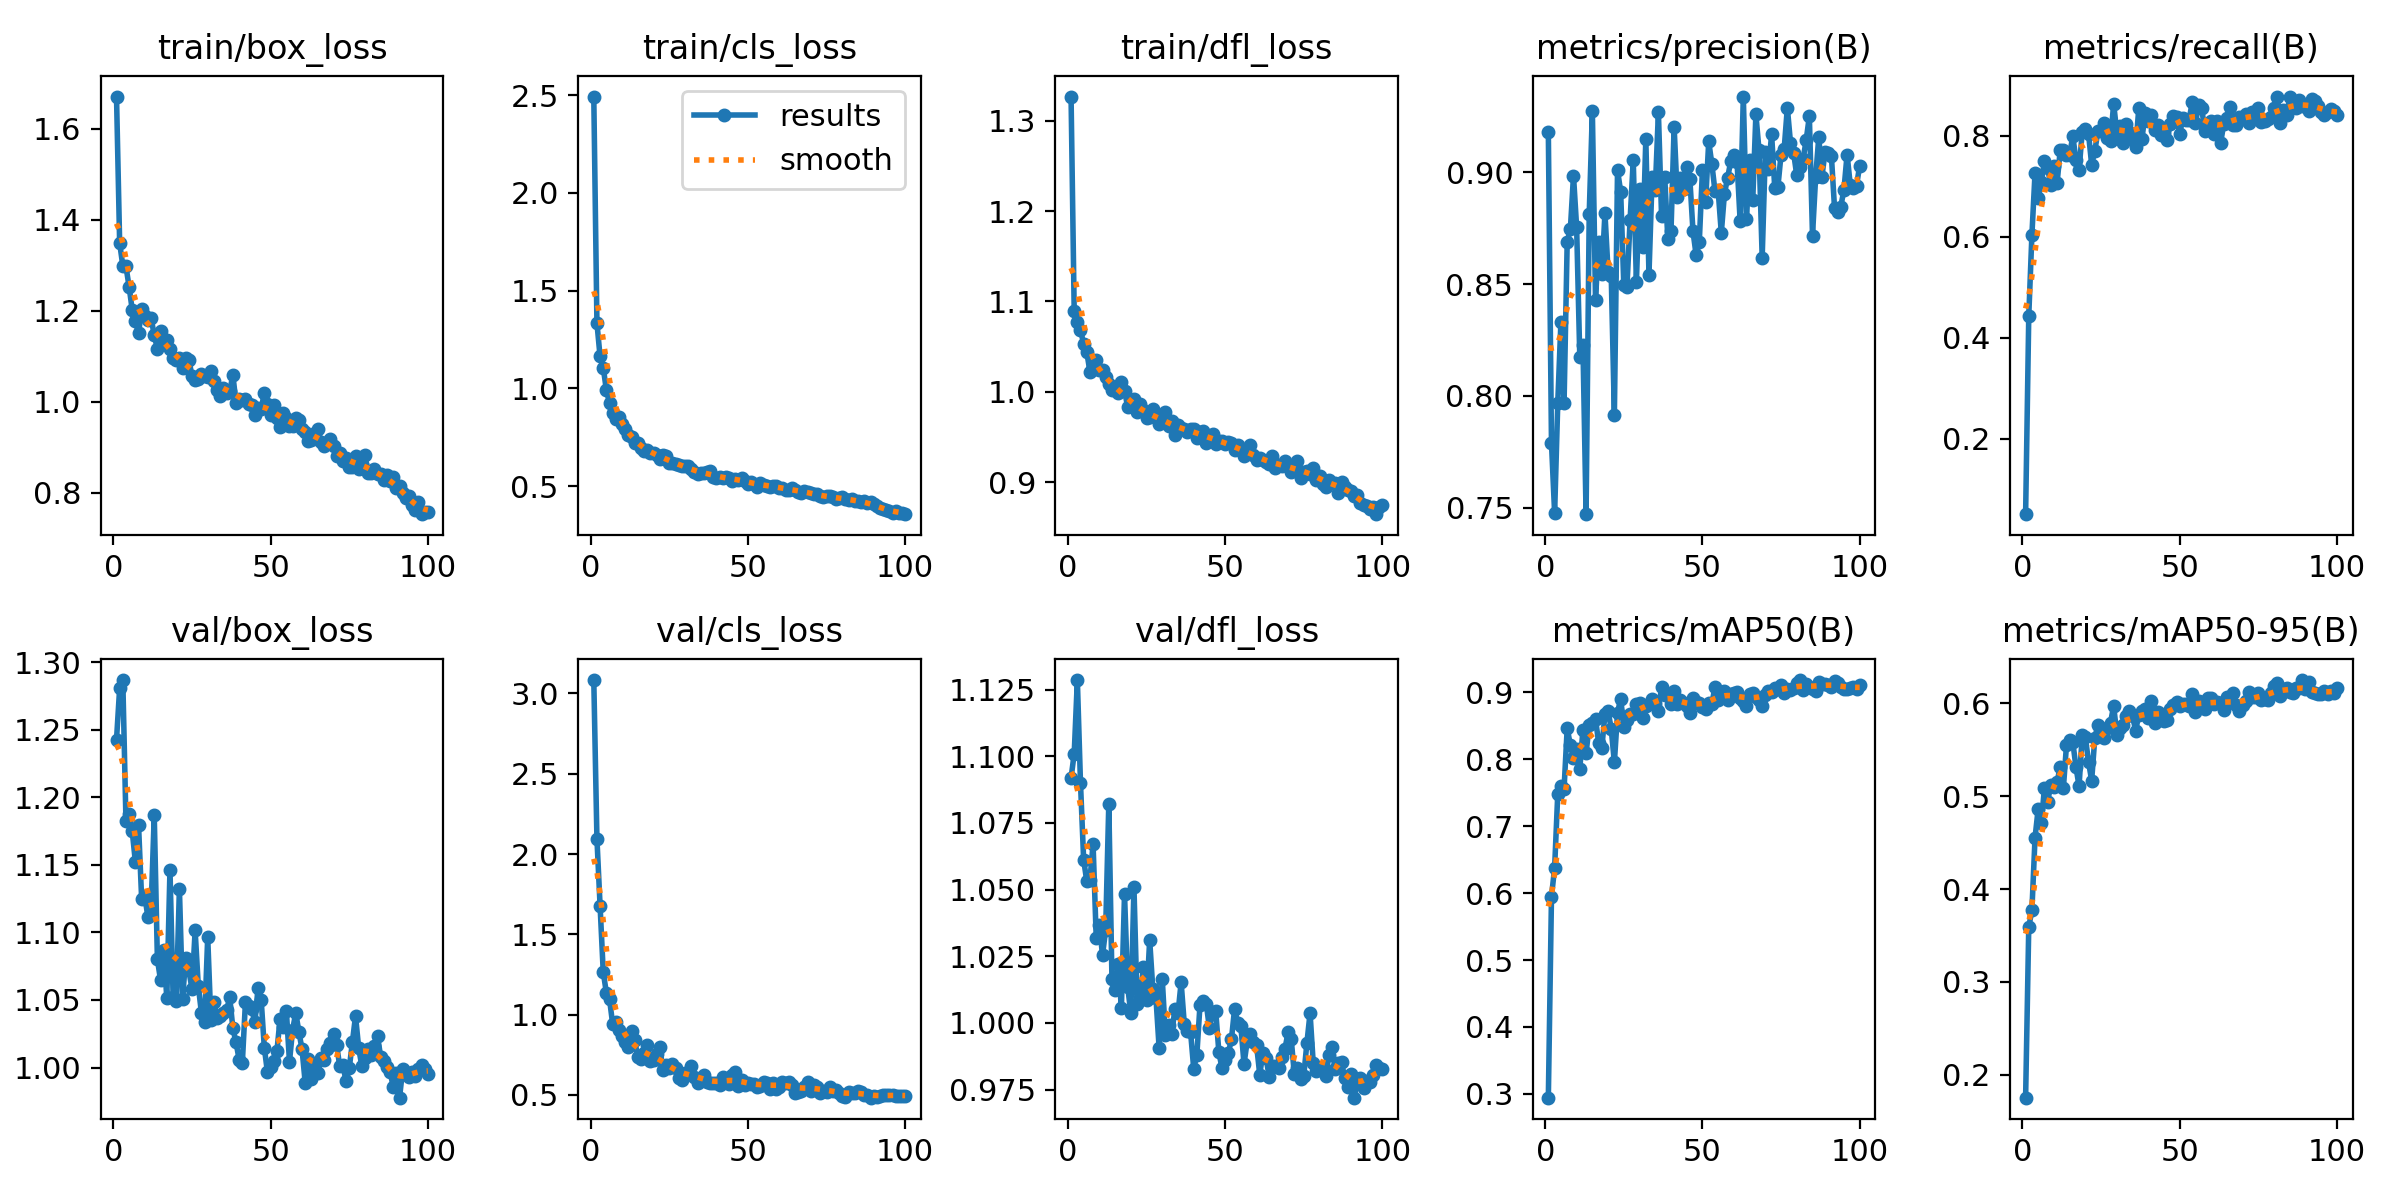

Ultralytics 8.3.231  Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1617.8602.2 MB/s, size: 476.8 KB)
val: Scanning D:\Workspace\Learning\Subjects\Image_Processing\Labs\Lab5\yolo_dir\labels\val.cache... 171 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 170.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 3.6it/s 3.1s0.2s
                   all        171        712      0.909      0.857      0.912      0.624
             with_mask        156        607      0.926      0.924      0.959      0.691
          without_mask         53        105      0.893       0.79      0.865      0.557
Speed: 3.2ms preprocess, 7.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to D:\Workspace\Learning\Subjects\Image_Processing\Labs\

In [20]:
display(Image(filename='./runs/detect/mask_detection_model/confusion_matrix.png'))

display(Image(filename='./runs/detect/mask_detection_model/results.png'))

metrics = model.val()
print(f"mAP50: {metrics.box.map50}")
print(f"mAP50-95: {metrics.box.map}")

# Testing

In [21]:
model = YOLO('./runs/detect/mask_detection_model/weights/best.pt') 


image 1/1 d:\Workspace\Learning\Subjects\Image_Processing\Labs\Lab5\MIT-Masks-Morality-01.jpg: 448x640 11 with_masks, 1 without_mask, 15.8ms
Speed: 2.5ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


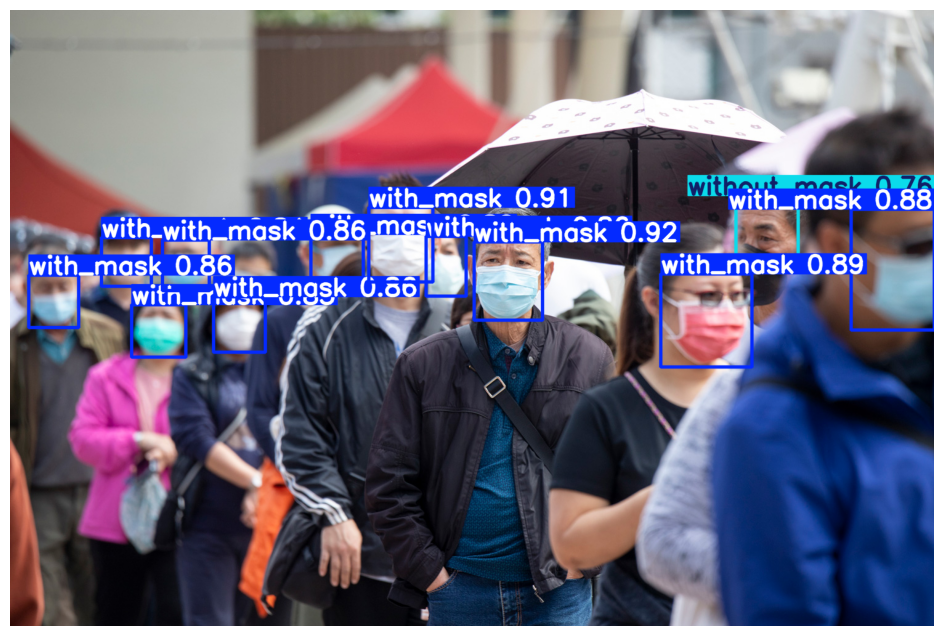

In [36]:
test_img_path = 'MIT-Masks-Morality-01.jpg' 

results = model.predict(source=test_img_path, conf=0.5) 

for result in results:
    res_plotted = result.plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Deployment

You can find the deployed model at [Deployment of Mask Wearing Detection System with YOLOv8](https://huggingface.co/spaces/SaitoHoujou/Mask_Wearing_Detection)

# Gradio app

In [37]:
def predict_image(image):
    results = model.predict(image, conf=0.5)
    
    res_plotted = results[0].plot()
    return cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

In [ ]:
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Uploaded Image"),
    outputs=gr.Image(type="numpy", label="Detecting Result"),
    title="MASK WEARING DETECTION",
    description="Upload image"
)

iface.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://57d8d68cc24c2906cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



0: 448x640 1 with_mask, 170.7ms
Speed: 58.0ms preprocess, 170.7ms inference, 10.7ms postprocess per image at shape (1, 3, 448, 640)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://57d8d68cc24c2906cf.gradio.live
